<a href="https://colab.research.google.com/github/miko-laj/DA-DS-example-projects/blob/main/Clustering_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an unsupervised clustering exercise based on earthquake data provided by EPAM systems for training through bds_courseware.

The goal is to produce and compare three clustering models. In this notebook I'm going with KNN, DBScan and Agglomerative Clustering

In [1]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS


print("Dataset names: ", HOMEWORK_DATASETS.keys())
name = "quake"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])
print(df.head(2))
print(df.shape)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Dataset names:  dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])
   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


In [ ]:
!pip install sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 33.7 MB/s eta 0:00:00


In [ ]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import sweetviz as sv
import plotly.express as px
import plotly.graph_objects as go
import itertools
import plotly.subplots as sp
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm as tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import make_scorer, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples, davies_bouldin_score, f1_score

I'm opting in for quick EDA option this time around

In [ ]:
sweet_report = sv.analyze(df)

                                             |          | [  0%]   00:00 -> (? left)

In [ ]:
sweet_report.show_html('sweet_report.html')

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



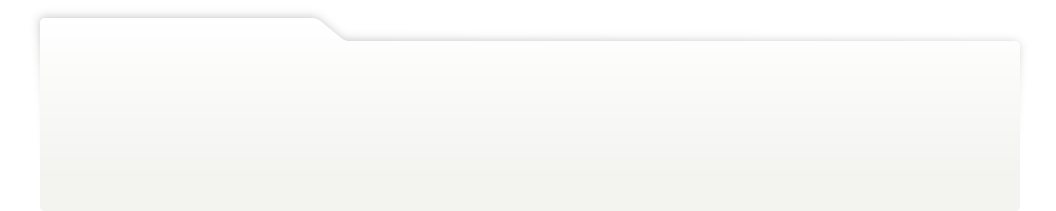
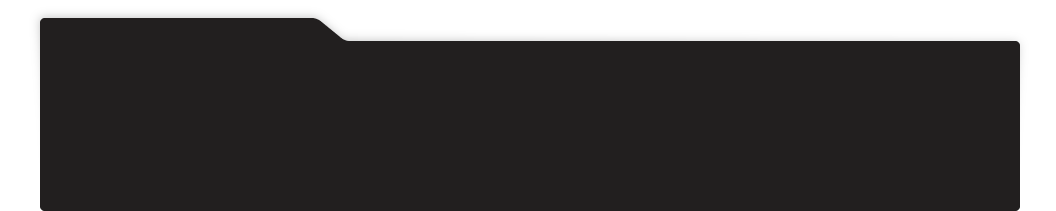
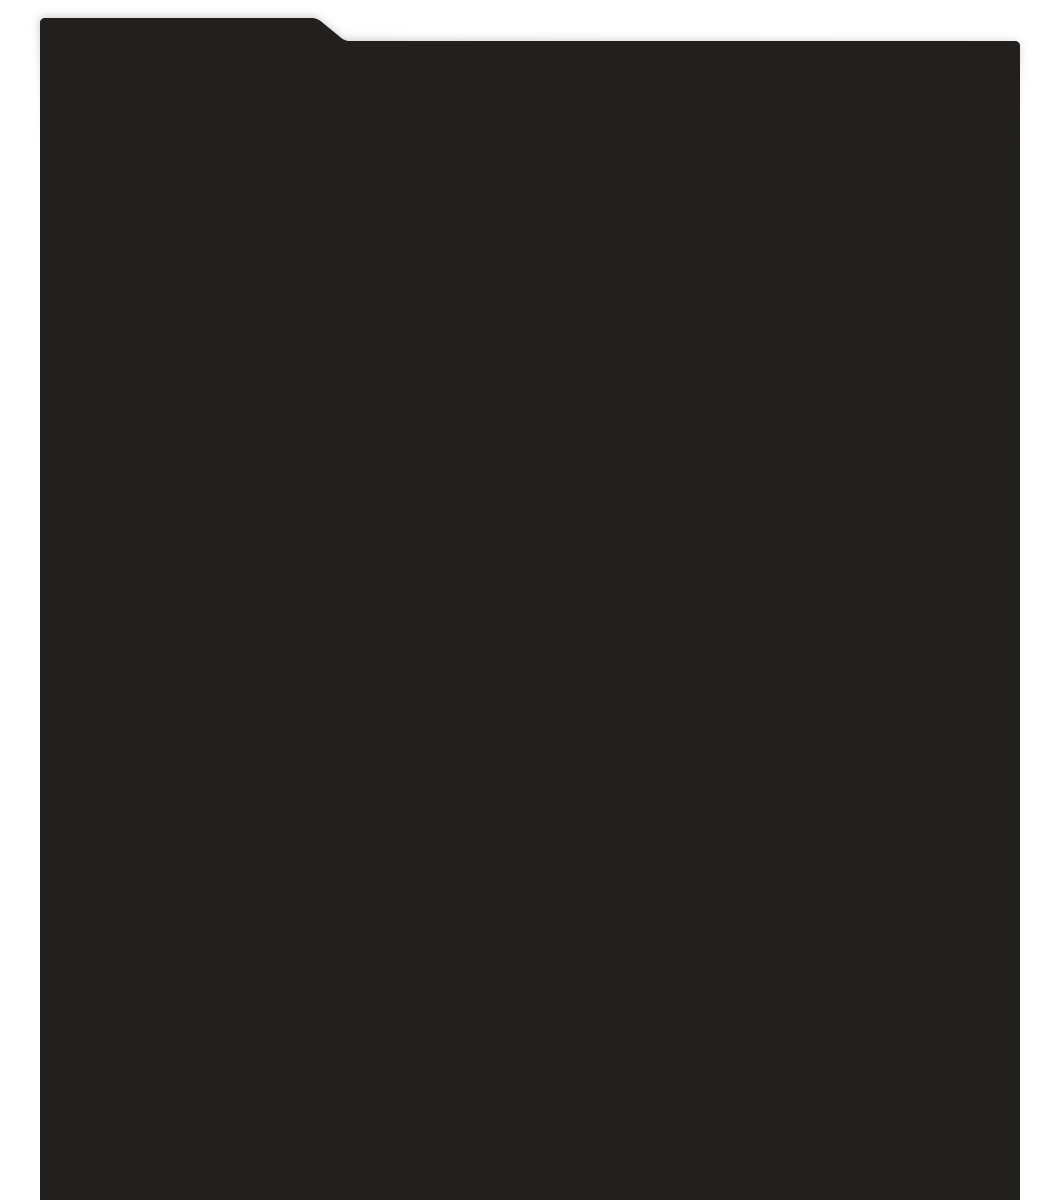
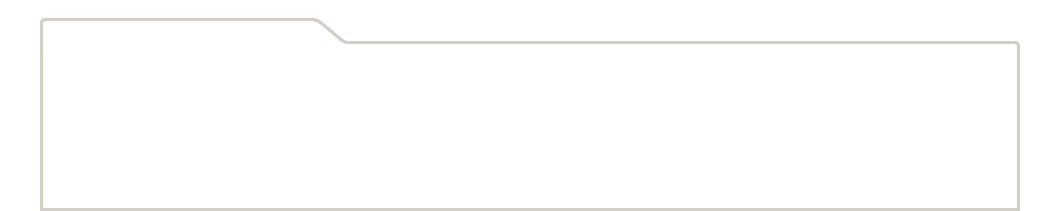
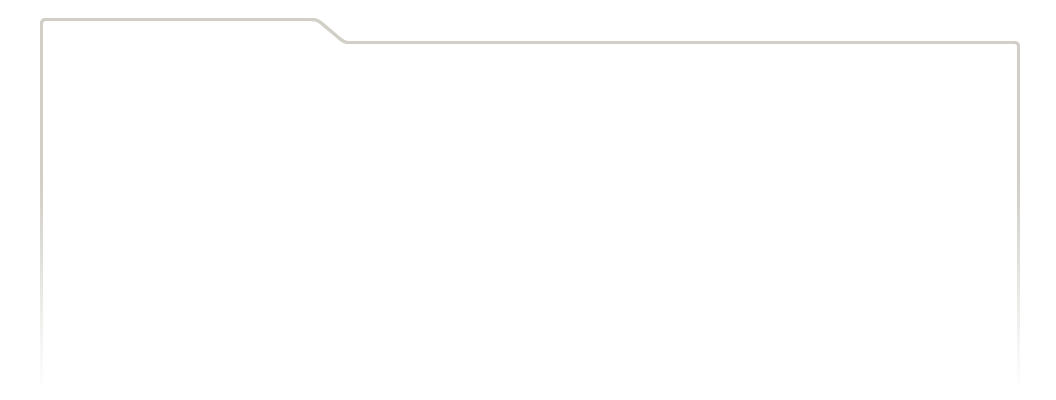
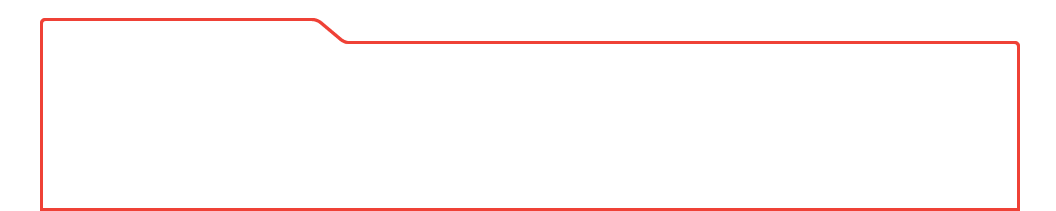
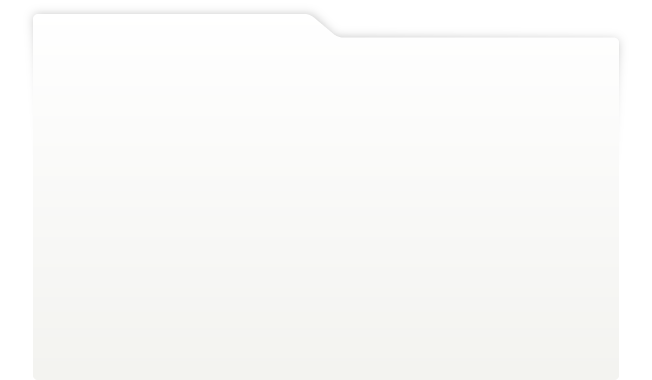
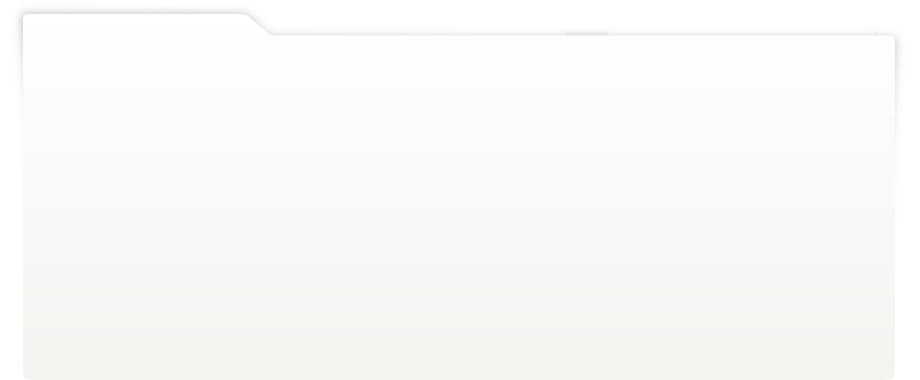
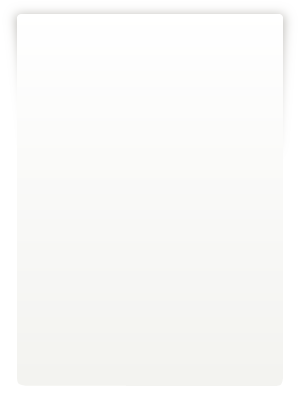
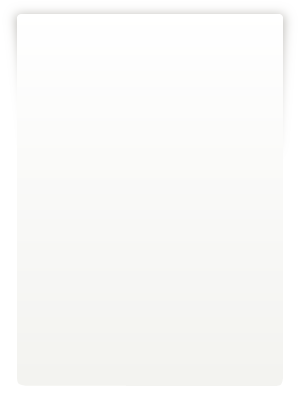
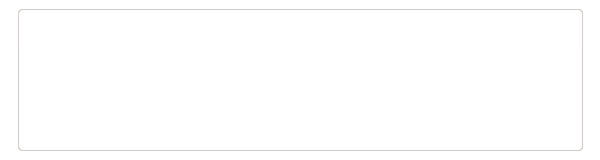
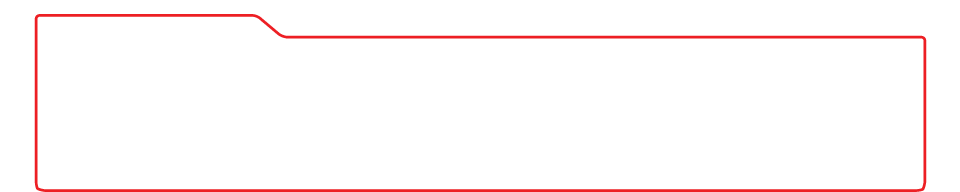
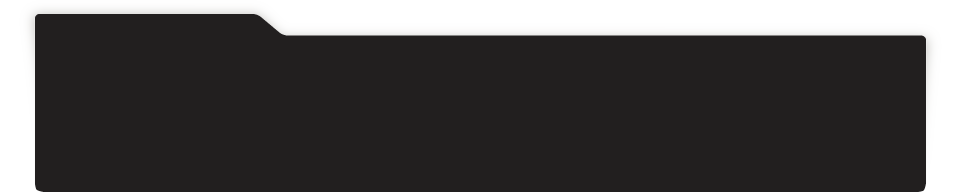
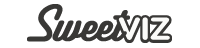
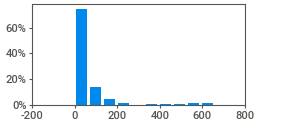
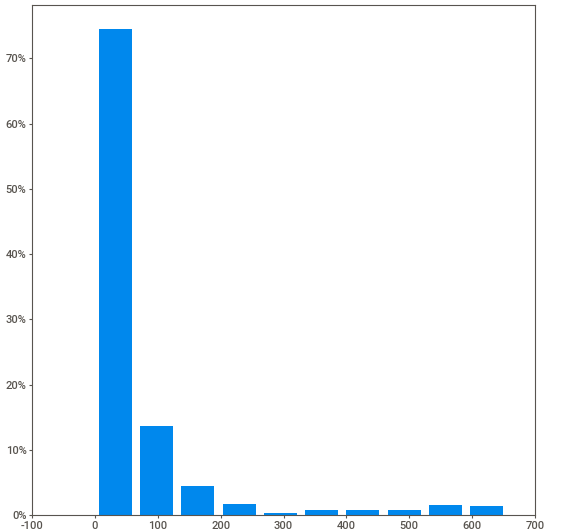
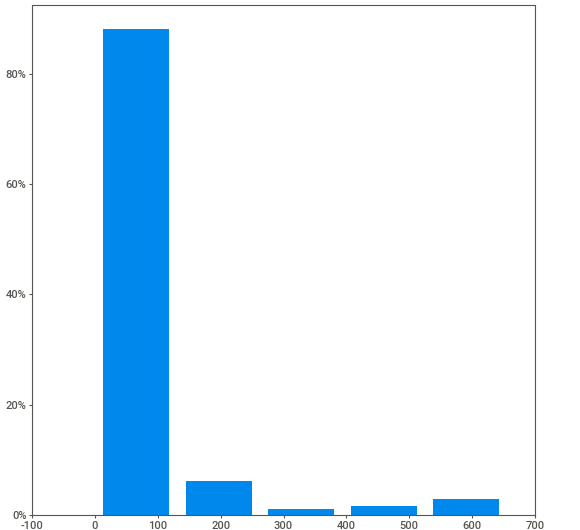
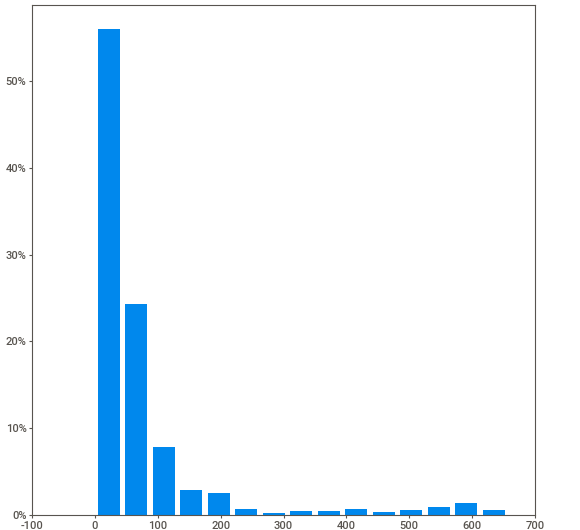
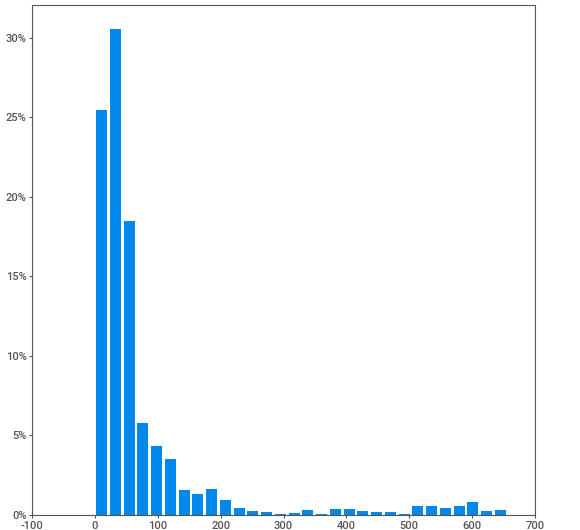
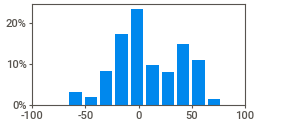
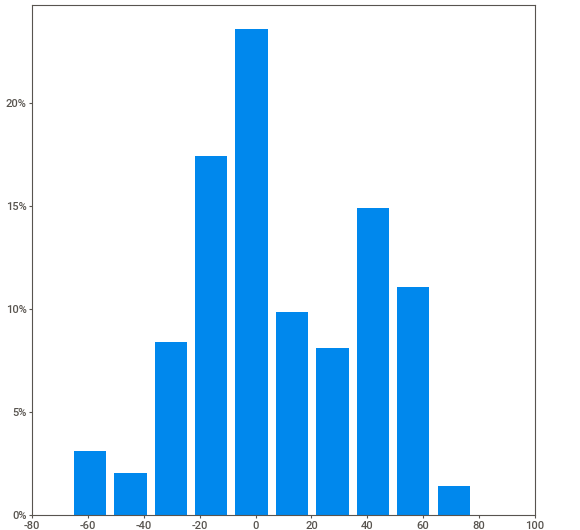
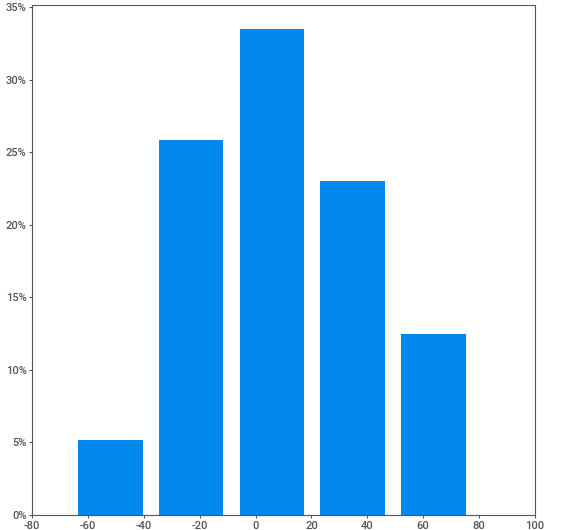
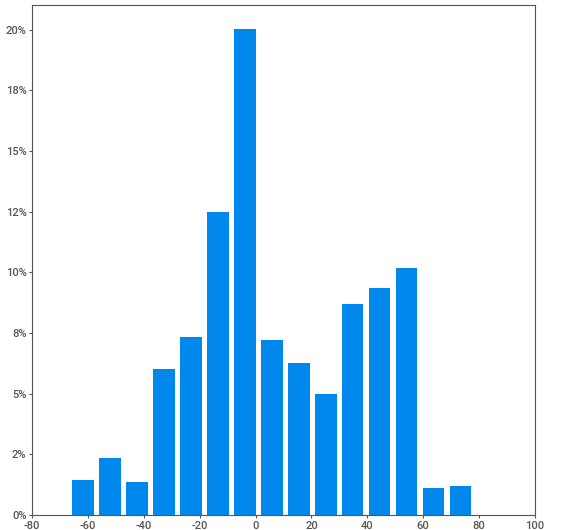
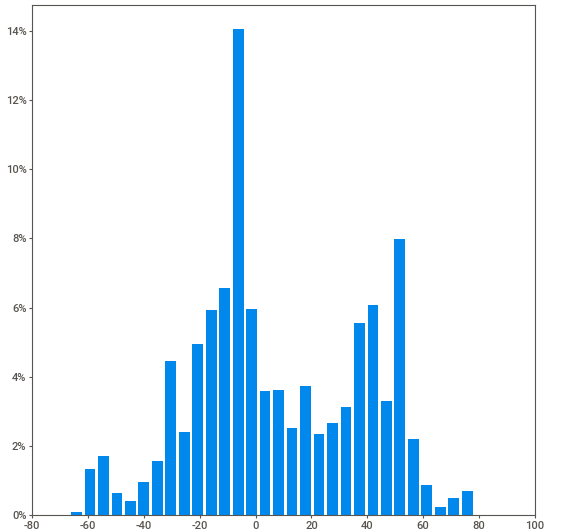
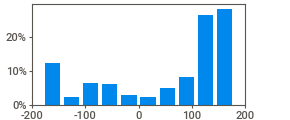
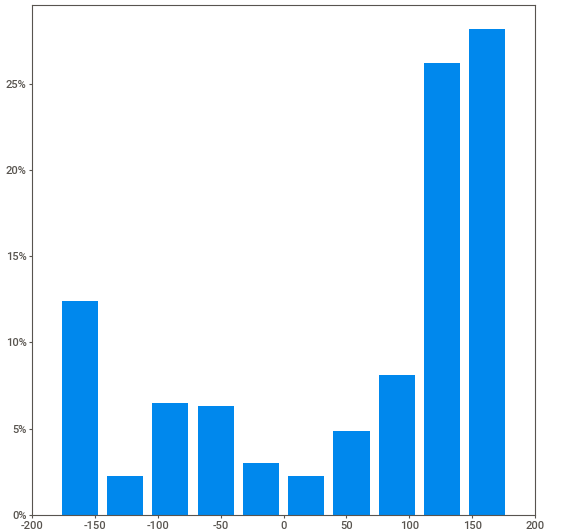
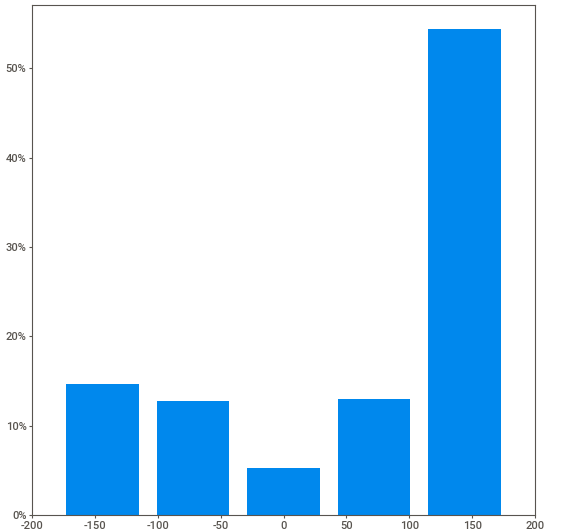
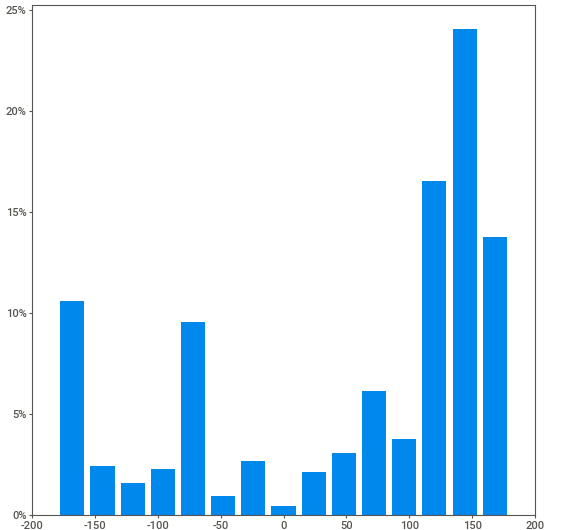
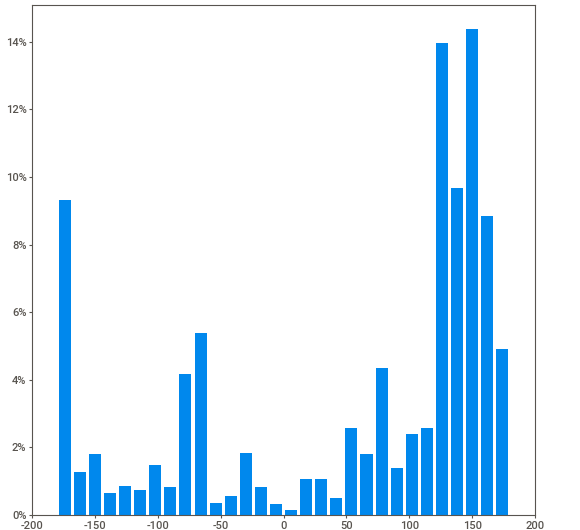
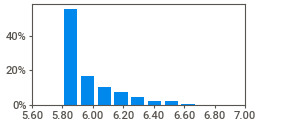
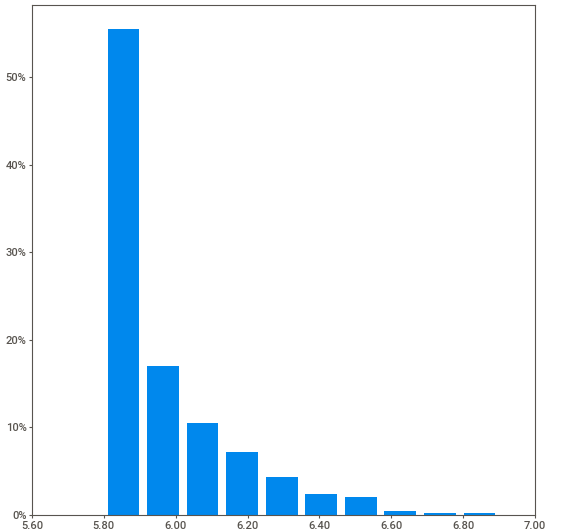
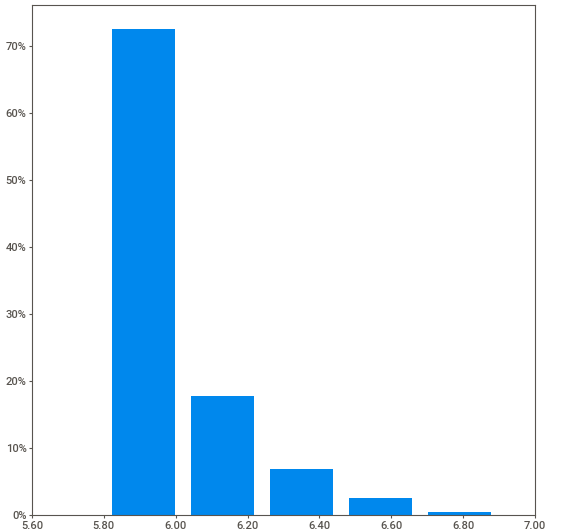
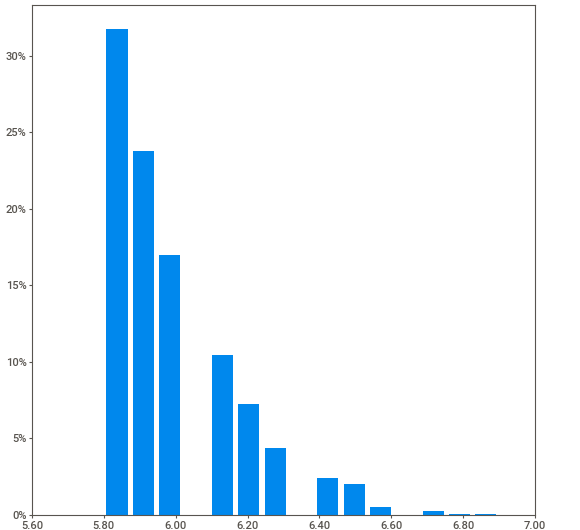
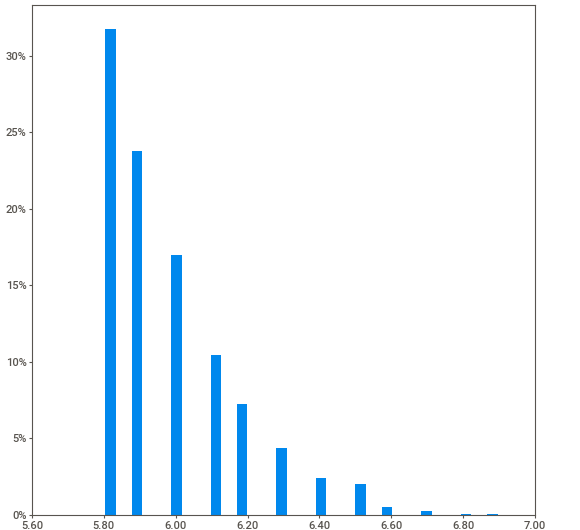
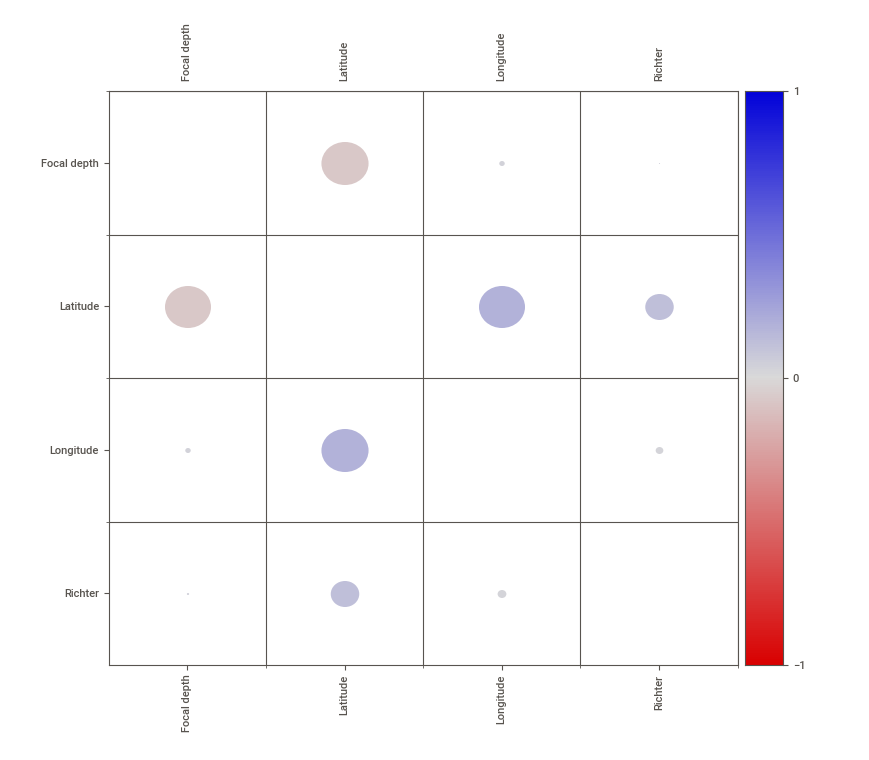
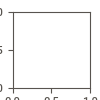

In [ ]:
sweet_report.show_notebook(w=1200, h=1000, scale=1)

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.columns

Index(['Focal depth', 'Latitude', 'Longitude', 'Richter'], dtype='object')

Preprocessing step - richter scale is not linear so I'm using a log transformer,  standard for focal depth and for longitude and latitude a custom circular encoding to maintain information such as that -180 and 180 longitude are in fact really close not really far

In [ ]:
def circular_encoding(x):
    x_rad = x * np.pi / 180.0
    return np.concatenate([np.sin(x_rad), np.cos(x_rad)], axis=1)

depth_scaler = StandardScaler()
scale_scaler = FunctionTransformer(func=np.log1p)

preprocessor = ColumnTransformer(
    transformers=[
        ('depth', depth_scaler, ['Focal depth']),
        ('location', FunctionTransformer(func=circular_encoding), ['Longitude', 'Latitude']),
        ('scale', scale_scaler, ['Richter'])
    ])

df_scaled = preprocessor.fit_transform(df)

Building k-means

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=0)
kmeans.fit(df_scaled)

KMeans(n_clusters=15, random_state=0)

In [ ]:
labels_km = kmeans.labels_

In [ ]:
df_scaled_with_labels = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame({'labels': labels_km})], axis=1)

In [ ]:
fig = px.scatter_3d(df_scaled_with_labels, x=0, y=1, z=2, color='labels')
fig.update_traces(marker=dict(size=5))
                              

fig.show()

For easier interpretation i'm going to plot every algorythm tried on the map

In [ ]:
df['labels'] = labels_km


fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="labels",
                        zoom=1, mapbox_style='carto-darkmatter', width = 2000, height = 800)
fig.show()

In [ ]:

scores = []
k_range = range(2, 25)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_scaled)
    scores.append(kmeans.inertia_)


fig = go.Figure()
fig.add_trace(go.Scatter(x=list(k_range), y=scores, mode='lines+markers'))
fig.update_layout(title='Elbow method for optimal k',
                  xaxis_title='Number of clusters',
                  yaxis_title='Explained variation')
fig.show()

Judging from the graph the optimum number of  looks like 7 to me

In [ ]:
kmeans = KMeans(n_clusters=7, random_state=0)
kmeans.fit(df_scaled)

KMeans(n_clusters=7, random_state=0)

In [ ]:
labels_km = kmeans.labels_

In [ ]:
df_scaled_with_labels = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame({'labels': labels_km})], axis=1)

In [ ]:
fig = px.scatter_3d(df_scaled_with_labels, x=0, y=1, z=2, color='labels')
fig.update_traces(marker=dict(size=5))
                              

fig.show()

In [ ]:
df['labels'] = labels_km


fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="labels",
                        zoom=1, mapbox_style='carto-darkmatter', width = 2000, height = 800)
fig.show()

#DBScan

In [ ]:
epsilon_param_options = np.arange(0.001, 10, 0.01)
min_samples_param_options = np.arange(2, df_scaled.shape[1]+1, 1)
param_grid = itertools.product(epsilon_param_options, min_samples_param_options)

print('Amount of hyperparameters combinations: {}'.format(len(epsilon_param_options) * len(min_samples_param_options)))

Amount of hyperparameters combinations: 5000


In [ ]:
params_dict = {}

for param_set in tqdm(param_grid, total=len(epsilon_param_options) * len(min_samples_param_options)):
  dbscan = DBSCAN(eps=param_set[0], min_samples=param_set[1])

  y_dbscan = dbscan.fit_predict(df_scaled)

  if len(set(y_dbscan)) > 1:
    params_dict['{}_{}_{}'.format(len(set(y_dbscan) - set([-1])), param_set[0], param_set[1])] = param_set
    score = silhouette_score(df_scaled, y_dbscan)
    print('eps={}, min_samples={}, n_clusters={}, silhouette score={}'.format(
      param_set[0], param_set[1], len(set(y_dbscan)), score))

  0%|          | 0/5000 [00:00<?, ?it/s]

eps=0.001, min_samples=2, n_clusters=20, silhouette score=-0.29046922367305017
eps=0.001, min_samples=3, n_clusters=10, silhouette score=-0.1774801013601725
eps=0.001, min_samples=4, n_clusters=7, silhouette score=0.015855088937906405
eps=0.001, min_samples=5, n_clusters=3, silhouette score=-0.00016651823279924076
eps=0.001, min_samples=6, n_clusters=2, silhouette score=-0.004958482188826993
eps=0.011, min_samples=2, n_clusters=57, silhouette score=-0.6469515961823638
eps=0.011, min_samples=3, n_clusters=13, silhouette score=-0.4792090906660439
eps=0.011, min_samples=4, n_clusters=7, silhouette score=0.0331936402819947
eps=0.011, min_samples=5, n_clusters=6, silhouette score=0.033725672530609575
eps=0.011, min_samples=6, n_clusters=5, silhouette score=0.02925580946455124
eps=0.020999999999999998, min_samples=2, n_clusters=157, silhouette score=-0.5264647790458039
eps=0.020999999999999998, min_samples=3, n_clusters=37, silhouette score=-0.5974236216122454
eps=0.020999999999999998, min_s

In [ ]:
best_silhouette = -1
best_params = None

for params_key, params_value in params_dict.items():
    dbscan = DBSCAN(eps=params_value[0], min_samples=params_value[1])
    cluster_labels = dbscan.fit_predict(df_scaled)
    
    if len(set(cluster_labels)) > 1:
        silhouette = silhouette_score(df_scaled, cluster_labels)
        
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = params_value

print("Best hyperparameters for DBSCAN: eps={}, min_samples={}".format(best_params[0], best_params[1]))

Best hyperparameters for DBSCAN: eps=0.6409999999999999, min_samples=2


In [ ]:

best_calinski = float('-inf')
best_params = None

for params_key, params_value in params_dict.items():
    dbscan = DBSCAN(eps=params_value[0], min_samples=params_value[1])
    cluster_labels = dbscan.fit_predict(df_scaled)
    
    if len(set(cluster_labels)) > 1:
        calinski = calinski_harabasz_score(df_scaled, cluster_labels)
        
        if calinski > best_calinski:
            best_calinski = calinski
            best_params = params_value

print("Best hyperparameters for DBSCAN: eps={}, min_samples={}".format(best_params[0], best_params[1]))

Best hyperparameters for DBSCAN: eps=0.4609999999999999, min_samples=6


first DBscan tuned by silhouette

In [ ]:
dbscan = DBSCAN(eps=0.6409999999999999, min_samples=2)

In [ ]:

dbscan.fit(df_scaled)


labels_db = dbscan.labels_


df_scaled_with_labels = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame({'labels': labels_db})], axis=1)


fig = px.scatter_3d(df_scaled_with_labels, x=0, y=1, z=2, color='labels')
fig.update_traces(marker=dict(size=5))


fig.show()

In [ ]:
df['labels'] = labels_db


fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="labels",
                        zoom=1, mapbox_style='carto-darkmatter', width = 2000, height = 800)
fig.show()

This is bad. Really bad. Let's see if Calinski-Harabasz did better 

In [ ]:
dbscan = DBSCAN(eps=0.4609999999999999, min_samples=6)

In [ ]:
dbscan.fit(df_scaled)


labels_db = dbscan.labels_


df_scaled_with_labels = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame({'labels': labels_db})], axis=1)


fig = px.scatter_3d(df_scaled_with_labels, x=0, y=1, z=2, color='labels')
fig.update_traces(marker=dict(size=5))


fig.show()

In [ ]:
df['labels'] = labels_db


fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="labels",
                        zoom=1, mapbox_style='carto-darkmatter', width = 2000, height = 800)
fig.show()

Not much better, really

#Agglomerative clustering

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters= 6)

In [ ]:
agglomerative.fit(df_scaled)

labels_ag = agglomerative.labels_


df_scaled_with_labels = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame({'labels': labels_ag})], axis=1)


fig = px.scatter_3d(df_scaled_with_labels, x=0, y=1, z=2, color='labels')
fig.update_traces(marker=dict(size=5))


fig.show()

In [ ]:
df['labels'] = labels_ag


fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="labels",
                        zoom=1, mapbox_style='carto-darkmatter', width = 2000, height = 800)
fig.show()

Not terrible. Let's check metrics

In [ ]:
def evaluate_labeled_metrics(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted')
    ari = adjusted_rand_score(y_true, y_pred)
    return f1, ari

def evaluate_unlabeled_metrics(X, y_pred):
    sil = silhouette_score(X, y_pred)
    ch = calinski_harabasz_score(X, y_pred)
    db = davies_bouldin_score(X, y_pred)
    return sil, ch, db

In [ ]:
print("Labeled Metrics")

f1, ari = evaluate_labeled_metrics(kmeans.labels_, dbscan.labels_)
print("  K-Means vs DBSCAN - F1-score:", f1)
print("  K-Means vs DBSCAN - ARI:", ari)

f1, ari = evaluate_labeled_metrics(kmeans.labels_, agglomerative.labels_)
print("  K-Means vs AgglomerativeClustering - F1-score:", f1)
print("  K-Means vs AgglomerativeClustering - ARI:", ari)

print("Unlabeled Metrics")
sil, ch, db = evaluate_unlabeled_metrics(df_scaled, kmeans.labels_)
print("  K-Means - Silhouette Score:", sil)
print("  K-Means - Calinski-Harabasz Index:", ch)
print("  K-Means - Davies-Bouldin Index:", db)

sil, ch, db = evaluate_unlabeled_metrics(df_scaled, dbscan.labels_)
print("  DBSCAN - Silhouette Score:", sil)
print("  DBSCAN - Calinski-Harabasz Index:", ch)
print("  DBSCAN - Davies-Bouldin Index:", db)

sil, ch, db = evaluate_unlabeled_metrics(df_scaled, agglomerative.labels_)
print("  AgglomerativeClustering - Silhouette Score:", sil)
print("  AgglomerativeClustering - Calinski-Harabasz Index:", ch)
print("  AgglomerativeClustering - Davies-Bouldin Index:", db)

Labeled Metrics
  K-Means vs DBSCAN - F1-score: 0.09274489388987171
  K-Means vs DBSCAN - ARI: 0.02591066721746887
  K-Means vs AgglomerativeClustering - F1-score: 0.13472288849756592
  K-Means vs AgglomerativeClustering - ARI: 0.6377361393007925
Unlabeled Metrics
  K-Means - Silhouette Score: 0.39976996170483264
  K-Means - Calinski-Harabasz Index: 1701.686804980631
  K-Means - Davies-Bouldin Index: 0.8014644681140253
  DBSCAN - Silhouette Score: 0.39541363436839155
  DBSCAN - Calinski-Harabasz Index: 268.2842320482544
  DBSCAN - Davies-Bouldin Index: 1.3735138181496949
  AgglomerativeClustering - Silhouette Score: 0.3830092095837207
  AgglomerativeClustering - Calinski-Harabasz Index: 1568.749090635251
  AgglomerativeClustering - Davies-Bouldin Index: 0.9614083808873648


Either DB scan did really poorly or there was something wrong with my parameters tuning. Either way, K-means did alright and it's my choice for the best performer this time around, with agglomerative clustering ever so slightly behind.